In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm_notebook as tqdm

import torchvision
# Then package torchvision, that has data loaders for common datasets such as 
# Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., 
# torchvision.datasets and torch.utils.data.DataLoader.
import torchvision.transforms as transforms

# CIFAR10 dataset
#     classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. 
#     images: size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.
# The output of torchvision datasets are PILImage images of range [0, 1], which then we have to transform 
# into normalized Tensors with range [-1, 1]

%matplotlib inline
random.seed(31)
torch.manual_seed(31)


# Utility functions

In [5]:
def image_show(img):
    img = img / 2 + 0.5 #normalization
    np_image = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    plt.show()

def image_grid_show(image_grid):
    image_show(torchvision.utils.make_grid(image_grid, nrow=batch_size//2))
    


# Netword class definition

In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channels (planes, rgb), 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        # 6 input image channels, 16 output channels, 5x5 square convolution kernel        
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # prepare the input for the fully connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
        


# Training the network

## Default parameters

In [35]:
batch_size=10
epochs=3

## Data preparation & exploration

In [36]:
# Load and normalizing the CIFAR10 training and test datasets using torchvision
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Each input image has shape 'torch.Size([3, 32, 32])'


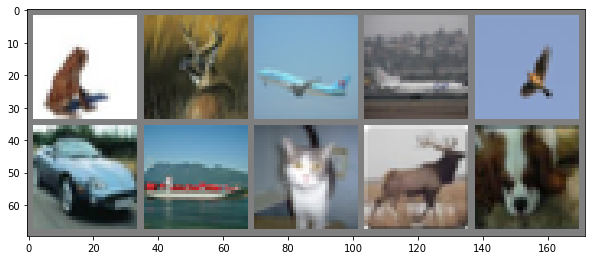

frog , deer , plane, plane, bird , car  , ship , cat  , deer , dog  


In [37]:
# Let's see how some train examples look like

iterator = iter(train_loader)
images, labels = iterator.next() # get the next batch of input data (images)
print(f"Each input image has shape '{images[0].size()}'")
image_grid_show(images)
print(", ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

## Network instatiation and start the training loop

In [44]:
net = Net()  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print(net)
params = list(net.parameters())
print(f"conv1's .weight size: {params[0].size()}") 
print(f"conv1's .biases size: {params[1].size()}") 

from torchsummary import summary
summary(net, input_size=(3, 32, 32))

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
conv1's .weight size: torch.Size([6, 3, 3, 3])
conv1's .biases size: torch.Size([6])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 30, 30]             168
         MaxPool2d-2            [-1, 6, 15, 15]               0
            Conv2d-3           [-1, 16, 11, 11]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
        

In [39]:
# the training loop

for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = 0.0
    for iteration, data in tqdm(enumerate(train_loader, 0), desc= "Batches"):
        inputs, labels = data
        # clean up all the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()   # `.item()` to get the value of a tensor
        if iteration % 2000 == 1999:
            print(f"Epoch {epoch + 1}, iteration {iteration + 1} -> loss: {(running_loss / 2000):.3f}")
            running_loss = 0.0

print("Training finished")

RuntimeError: size mismatch, m1: [10 x 400], m2: [160 x 120] at /Users/distiller/project/conda/conda-bld/pytorch_1565272526878/work/aten/src/TH/generic/THTensorMath.cpp:752

# Evaluate the model

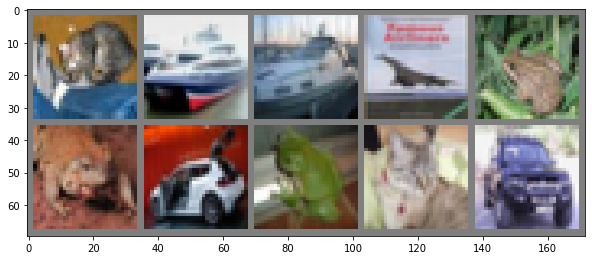

Ground truth:
cat  , ship , ship , plane, frog , frog , car  , frog , cat  , car  

Prediction:
ship , ship , ship , ship , deer , frog , car  , frog , cat  , car  


In [31]:
test_iterator = iter(test_loader)
images, labels = test_iterator.next()

image_grid_show(images)
print("Ground truth:")
print(", ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))


# Now submit these images to the network classifier
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print("\nPrediction:")
print(", ".join(f"{classes[predicted[j]]:5s}" for j in range(batch_size)))

In [32]:
# classify the full test set
correct = 0
total = 0
with torch.no_grad():                      # avoid keeping the gradients
    for data in test_loader:
        inputs, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on {total} test images: {(100 * correct / total):.2f}")

Accuracy on 10000 test images: 9.90


In [33]:
# Measuring acc per class
class_correct = [0] * len(classes)
class_total = [0] * len(classes)
with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=10000//batch_size, desc="Batches"):
        inputs, labels = data
        outputs = net(images)
        # the net returns a tensor per image 
        # containing the classification 'score' per classs.
        # Thus, we use `.max` to identify the most probable classification
        _, predicted = torch.max(outputs, 1)
        is_correct = (predicted == labels).squeeze()
        for i in range(len(labels)):
            true_label = labels[i]
            class_correct[true_label] += is_correct[i].item()
            class_total[true_label] += 1

for i in range(len(classes)):
    print(f"Accuracy of {classes[i]:5s} : {(100 * class_correct[i] / class_total[i]):.2f}%")
            


Accuracy of plane : 0.00%
Accuracy of car   : 19.70%
Accuracy of bird  : 0.00%
Accuracy of cat   : 10.10%
Accuracy of deer  : 9.30%
Accuracy of dog   : 0.00%
Accuracy of frog  : 19.80%
Accuracy of horse : 0.00%
Accuracy of ship  : 40.10%
Accuracy of truck : 0.00%
